In [1]:
#import matplotlib with pdf as backend
import matplotlib as plt
#matplotlib.use('PDF')
from pylab import *
#from matplotlib.backends.backend_pdf import PdfPages

import wfdb 
import os
import numpy as np
import math
import sys
import scipy.stats as st
from sklearn.preprocessing import scale
import glob, os
from os.path import basename
from functools import partial, update_wrapper
from keras import regularizers

Using TensorFlow backend.


In [1]:
import tensorflow as tf
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,Bidirectional, GRU #could try TimeDistributed(Dense(...))
from keras.models import Sequential, load_model
from keras import optimizers,regularizers
from keras.layers.normalization import BatchNormalization
import keras.backend.tensorflow_backend as KTF
from keras.metrics import categorical_accuracy
from keras.callbacks import EarlyStopping

np.random.seed(42)




# functions
def get_ecg_data(datfile): 
    ## convert .dat/q1c to numpy arrays
    recordname=os.path.basename(datfile).split(".dat")[0]
    recordpath=os.path.dirname(datfile)
    cwd=os.getcwd()
    os.chdir(recordpath) ## somehow it only works if you chdir. 

    annotator='atr'
    annotation = wfdb.rdann(recordname, extension=annotator, sampfrom=0,sampto = None, pbdir=None)
    record = wfdb.rdsamp(recordname, sampfrom=0,sampto = None) #wfdb.showanncodes()

    Vctrecord=np.transpose(record.p_signals)
    VctAnnotationHot=np.zeros( (2,len(Vctrecord[1])), dtype=np.int)
    VctAnnotationHot[1] = 1;
    
    VctAnnotations=list(zip(annotation.sample,annotation.symbol)) ## zip coordinates + annotations (N),(t) etc)
    #print(VctAnnotations)
    for i in range(len(VctAnnotations)):
        if(  VctAnnotations[i][1] == '·' or 
           VctAnnotations[i][1] == 'N' or 
            VctAnnotations[i][1] == 'L' or  
            VctAnnotations[i][1] == 'R' or 
           VctAnnotations[i][1] == 'B' or 
           VctAnnotations[i][1] == 'A' or
           VctAnnotations[i][1] == 'a' or 
           VctAnnotations[i][1] == 'J' or 
           VctAnnotations[i][1] == 'S' or 
           VctAnnotations[i][1] == 'V' or  
           VctAnnotations[i][1] == 'r' or  
           VctAnnotations[i][1] == 'F' or 
           VctAnnotations[i][1] == 'e' or 
           VctAnnotations[i][1] == 'j' or
           VctAnnotations[i][1] == 'n' or 
           VctAnnotations[i][1] == 'E' or 
           VctAnnotations[i][1] == '/' or 
           VctAnnotations[i][1] == 'f' or
           VctAnnotations[i][1] == 'Q' or  
           VctAnnotations[i][1] == '?'):
            VctAnnotationHot[0][VctAnnotations[i][0]] = 1;  
            VctAnnotationHot[1][VctAnnotations[i][0]] = 0;  
    VctAnnotationHot=np.transpose(VctAnnotationHot)
    Vctrecord=np.transpose(Vctrecord) # transpose to (timesteps,feat)

    os.chdir(cwd)
    return Vctrecord, VctAnnotationHot



def splitseq(x,n,o):
	n = int(n)
	o = int(o)
	#split seq; should be optimized so that remove_seq_gaps is not needed. 
	upper= int(math.ceil( x.shape[0] / n) *n)
	print("splitting on",n,"with overlap of ",o,	"total datapoints:",x.shape[0],"; upper:",upper)
	for i in range(0,upper,n):
		#print(i)
		if i==0:
			padded=np.zeros( ( o+n+o,x.shape[1])   ) ## pad with 0's on init
			padded[o:,:x.shape[1]] = x[i:i+n+o,:]
			xpart=padded
		else:
			xpart=x[i-o:i+n+o,:]
		if xpart.shape[0]<i:

			padded=np.zeros( (o+n+o,xpart.shape[1])  ) ## pad with 0's on end of seq
			padded[:xpart.shape[0],:xpart.shape[1]] = xpart
			xpart=padded

		xpart=np.expand_dims(xpart,0)## add one dimension; so that you get shape (samples,timesteps,features)
		try:
			xx=np.vstack(  (xx,xpart) )
		except UnboundLocalError: ## on init
			xx=xpart
	print("output: ",xx.shape)
	return(xx)

def remove_seq_gaps(x,y):
	#remove parts that are not annotated <- not ideal, but quickest for now.
	window=150
	c=0
	cutout=[]
	include=[]
	print("filterering.")
	print("before shape x,y",x.shape,y.shape)
	for i in range(y.shape[0]):
		
		c=c+1
		if c<window :
			include.append(i)
		if sum(y[i,0:5])>0:
			c=0 
		if c >= window:
			#print ('filtering')
			pass
	x,y=x[include,:],y[include,:]
	print(" after shape x,y",x.shape,y.shape)
	return(x,y)


def normalize_new(x):
    for i in range(x.shape[0]):
        x[i] = scale( x[i], axis=0, with_mean=True, with_std=True, copy=True )
    return x

def normalizesignal(x):
	x=st.zscore(x, ddof=0)
	return x
def normalizesignal_array(x):
	for i in range(x.shape[0]):
		x[i]=st.zscore(x[i], axis=0, ddof=0)
	return x

def plotecg(x,y,begin,end):
	#helper to plot ecg
	plt.figure(1,figsize=(11.69,8.27))
	plt.subplot(211)
	plt.plot(x[begin:end,0])
	plt.subplot(211)
	plt.plot(y[begin:end,0])
	plt.subplot(211)
	plt.plot(y[begin:end,1])
	plt.subplot(211)
	plt.plot(y[begin:end,2])
	plt.subplot(211)
	plt.plot(y[begin:end,3])
	plt.subplot(211)
	plt.plot(y[begin:end,4])
	plt.subplot(211)
	plt.plot(y[begin:end,5])

	plt.subplot(212)
	plt.plot(x[begin:end,1])
	plt.show()

def plotecg_validation(x,y_true,y_pred,begin,end):
	#helper to plot ecg
	plt.figure(1,figsize=(11.69,8.27))
	plt.subplot(211)
	plt.plot(x[begin:end,0])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,0])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,1])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,2])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,3])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,4])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,5])

	plt.subplot(212)
	plt.plot(x[begin:end,1])
	plt.subplot(212)
	plt.plot(y_true[begin:end,0])
	plt.subplot(212)
	plt.plot(y_true[begin:end,1])
	plt.subplot(212)
	plt.plot(y_true[begin:end,2])
	plt.subplot(212)
	plt.plot(y_true[begin:end,3])
	plt.subplot(212)
	plt.plot(y_true[begin:end,4])
	plt.subplot(212)
	plt.plot(y_true[begin:end,5])


def LoadMatFiles(datfiles): 
    for datfile in datfiles:
        print(datfile)
        if basename(datfile).split(".",1)[0] in exclude:
            continue
        if os.path.isfile(datfile):
            dat_ = loadmat(datfile)
            data_file = dat_['data_']
            x = data_file[:,0:2]
            y_ = data_file[:,2]
            y = np.zeros([len(y_), 2])
            y[np.where(y_ != 1)[0], 0] = 1
            y[np.where(y_ == 1)[0], 1] = 1

            xs,y=splitseq(x,1000,0),splitseq(y,1000,0) ## create equal sized numpy arrays of n size and overlap of o 

            x = normalize_new(xs)
            ## todo; add noise, shuffle leads etc. ?
            try: ## concat
                xx=np.vstack(  (xx,x) )
                yy=np.vstack(  (yy,y) )
            except NameError: ## if xx does not exist yet (on init)
                xx = x
                yy = y
    return(xx,yy)            
    
def LoaddDatFiles(datfiles):  
    for datfile in datfiles:
        print(datfile)
        if basename(datfile).split(".",1)[0] in exclude:
            continue
        qf=os.path.splitext(datfile)[0]+'.atr'
        if os.path.isfile(qf):
            #print("yes",qf,datfile)
            x,y=get_ecg_data(datfile)

            x,y=splitseq(x,1000,0),splitseq(y,1000,0) ## create equal sized numpy arrays of n size and overlap of o 

            x = normalize_new(x)
            ## todo; add noise, shuffle leads etc. ?
            try: ## concat
                xx=np.vstack(  (xx,x) )
                yy=np.vstack(  (yy,y) )
            except NameError: ## if xx does not exist yet (on init)
                xx = x
                yy = y
    return(xx,yy)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_session(gpu_fraction=0.8):
	#allocate % of gpu memory.
	num_threads = os.environ.get('OMP_NUM_THREADS')
	gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
	if num_threads:
		return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
	else:
		return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from keras import backend as K

import numpy as np
from keras.activations import softmax
from keras.objectives import categorical_crossentropy

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

def build_model_gru():
    #data_dim = X_data.shape[2]
    #timesteps = X_data.shape[1]
    model = Sequential()
    model.add(BatchNormalization(input_shape=(seqlength, features)))  
    model.add(GRU(output_dim=50,init ='glorot_normal',
         return_sequences=True, W_regularizer=regularizers.l2(0.00),U_regularizer=regularizers.l1(0.01),dropout_W =0.2 ))
    model.add(GRU(output_dim=50,init ='glorot_normal',
        return_sequences=True,W_regularizer=regularizers.l2(0.00),U_regularizer=regularizers.l1(0.01),dropout_W =0.2))
    model.add(GRU(50,init ='glorot_normal',return_sequences=False,dropout_W =0.01, W_regularizer=regularizers.l2(0.00),U_regularizer=regularizers.l1(0.01)))
    model.add(Dense(dimout, init='glorot_normal'))
    model.add(Activation('softmax'))

    #weights = np.ones((dimout,))
    weights = np.array([0.8, 500.0])
    model.compile(loss=weighted_categorical_crossentropy(weights),optimizer='Adam')
    return model

def getmodel_simple():
    # create model
    model = Sequential()
    model.add(Dense(1000,W_regularizer=regularizers.l2(l=0.01), input_shape=(seqlength, features)))
    model.add(Dense(2000, activation='relu'))
    model.add(Dense(dimout, activation='softmax'))
    # Compile model
    weights = np.array([128., 0.1])
    adam = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)
    model.compile(loss=weighted_categorical_crossentropy(weights),optimizer=adam, metrics=['accuracy']) #(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) 
    return model

def getmodel():
    model = Sequential()
    model.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=(seqlength, features)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))#, input_shape=(seqlength, features)) ) ### bidirectional ---><---
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(dimout, activation='softmax'))
    adam = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    weights = np.array([64.0, 0.1,])
    model.compile(loss=weighted_categorical_crossentropy(weights),optimizer=adam, metrics=['accuracy']) #(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) 
    print(model.summary())
    return(model)

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


def getmodel_one():
    model = Sequential()
    model.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=(seqlength, features)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))#, input_shape=(seqlength, features)) ) ### bidirectional ---><---
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(dimout, activation='sigmoid'))
    adam = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    weights = np.array([64.0, 0.1,])
    model.compile(loss=f1_loss, #loss=weighted_categorical_crossentropy(weights), 
                  optimizer=adam, 
                  metrics=['categorical_accuracy', f1_m,precision_m, recall_m, matthews_correlation]) #(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) 
    print(model.summary())
    return(model)


def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


Using TensorFlow backend.


NameError: name 'np' is not defined

In [ ]:
## USE CPU otherwise need a lot of memory in the GPU
from keras import backend as K
import tensorflow as tf

num_cores = 4
GPU = 1
CPU = 0

if GPU:
    num_GPU = 1
    num_CPU = 6
if CPU:
    num_CPU = 7
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
KTF.set_session(session)

In [4]:
# CORRECTED LABELS
import os
qtdbpath="/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/"#sys.argv[1] ## first argument = qtdb database from physionet. 
datfiles=glob.glob(qtdbpath+"*.mat")
datfiles

['/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0306.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0404.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0606.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0159.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0206.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0405.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0111.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0136.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0410.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0613.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0203.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0210.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0103.mat',
 '/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e010

In [5]:
## EDB
#import os
#import wfdb

#qtdbpath="/home/federico/imec-nl/ECG-LSTM-Annotator/physionet/physiobank/database/edb/"#sys.argv[1] ## first argument = qtdb database from physionet. 

# load data
#datfiles=glob.glob(qtdbpath+"*.dat")
#datfiles

In [6]:
# load data
perct=0.81 #percentage training
percv=0.19 #percentage validation
exclude = set()
#exclude.update(["234"])# no P annotated:
#datfiles=glob.glob(qtdbpath+"*.dat")

In [7]:
from scipy.io import loadmat
for datfile in datfiles[0:1]:
    print(datfile)
    if basename(datfile).split(".",1)[0] in exclude:
        continue
    if os.path.isfile(datfile):
        dat_ = loadmat(datfile)
        data_file = dat_['data_']
        x = data_file[:,0:2]
        y_ = data_file[:,2]
        y = np.zeros([len(y_), 2])
        y[np.where(y_ != 1)[0], 0] = 1
        y[np.where(y_ == 1)[0], 1] = 1

/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0306.mat


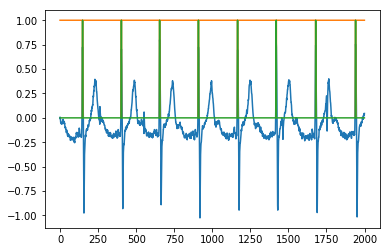

In [8]:
import mpld3
mpld3.enable_notebook()
plot(x[0:2000,0])
plot(y[0:2000])

In [9]:
inp_size = 1000;
xs,ys=splitseq(x,inp_size,0),splitseq(y,inp_size,0)
xs.shape

('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))


(1799, 1000, 2)

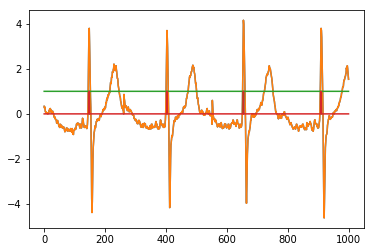

In [10]:
#only use first channel as it is not well labeled the second one
xs[:,:,1] = xs[:,:,0]
x = normalize_new(xs)
plot(x[0,:,:])
plot(ys[0,:,:])

In [30]:
xxt,yyt=LoadMatFiles(datfiles[ :int(round(len(datfiles)*perct)) ]) # training data. 
xxt,yyt=unison_shuffled_copies(xxt,yyt) ### shuffle
xxv,yyv=LoadMatFiles(datfiles[ -int(round(len(datfiles)*percv)): ] ) ## validation data.
seqlength=xxt.shape[1]
features=1#xxt.shape[2]
dimout=yyt.shape[2]
print("xxv/validation shape: {}, Seqlength: {}, Features: {}".format(xxv.shape[0],seqlength,features))

/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0306.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0404.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0606.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-An

('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0121.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0704.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0601.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('sp

/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0113.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0133.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0155.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-An

('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0125.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0417.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/edb_dataset/edb_e0115.mat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 1799999, '; upper:', 1799000)
('output: ', (1799, 1000, 2))
('sp

In [34]:
xxt.shape

(131327, 1000, 2)

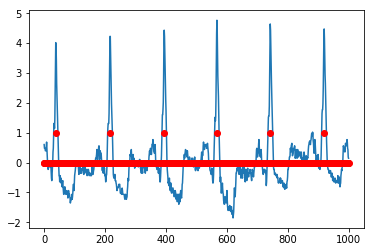

In [36]:
plot(xxt[1125,:,0])
plot(yyt[1125,:,1], 'ro')

In [37]:
yyt.shape

(131327, 1000, 2)

In [43]:
# USE BOTH CHANNELS
pcha=xxt[:,:,1]; 
pchb=xxt[:,:,0];
#xxv[:,:,1] = xxv[:,:,0];
yyt.shape[0]*2

all_x = np.vstack([pchb, pcha]) # only channel zero
all_x = np.expand_dims(all_x,2)
all_lab = np.vstack([yyt, yyt]) # only channel zero
print(all_lab.shape)
print(all_x.shape)


(262654, 1000, 2)
(262654, 1000, 1)


In [64]:
# call keras/tensorflow and build lstm model 
#index_ = np.linspace(0, xxt.shape[0]-1, xxt.shape[0] ).astype(int);
#shuffle(index_)

# TRAIN
KTF.set_session(session)

## early stopping monitoring mette
EarlyStopping(monitor='matthews_correlation', mode='max')

with tf.Session(): #switch to /cpu:0 to use cpu 
    #if not os.path.isfile('model_mitd_binary_noover.h5'):
    model =   getmodel_one() #build_model_gru() 
    #model = getmodel_simple();
    for this_eps in range(20):
        model.fit(all_x, all_lab, batch_size=100, epochs=1, verbose=1) # train the model
        model.save('model_edb_binary_noover_eps_f1loss_2ch_'+str(this_eps)+'_.h5')
        model.save_weights('model_weights_edb_binary_noover_eps_f1loss_2ch_'+str(this_eps)+'_.h5')

/home/federico/venv/lib/python2.7/site-packages/ipykernel_launcher.py:357: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, kernel_regularizer=<keras.reg..., input_shape=(1000, 1))`
/home/federico/venv/lib/python2.7/site-packages/ipykernel_launcher.py:361: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_regularizer=<keras.reg...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 1000, 32)          64        
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 1000, 128)         49664     
_________________________________________________________________
dropout_41 (Dropout)         (None, 1000, 128)         0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 1000, 128)         512       
_________________________________________________________________
dense_62 (Dense)             (None, 1000, 32)          4128      
_________________________________________________________________
dropout_42 (Dropout)         (None, 1000, 32)          0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 1000, 32)          128       
__________

In [55]:
## LOAD MITDB AND TEST ON IT
## MITDB
import os
import wfdb

qtdbpath_test="/home/federico/imec-nl/ECG-LSTM-Annotator/physionet/physiobank/database/mitdb/"#sys.argv[1] ## first argument = qtdb database from physionet. 

# load data
datfiles_test=glob.glob(qtdbpath_test+"*.dat")
datfiles_test


xxtmitdb,yytmitdb=LoaddDatFiles(datfiles_test) # training data. 
xxtmitdb,yytmitdb=unison_shuffled_copies(xxtmitdb,yytmitdb) ### shuffle


# USE SINGLE CHANNEL
pcha=xxtmitdb[:,:,1]; 
pchb=xxtmitdb[:,:,0];

all_x_test = np.vstack([pchb]) # only channel zero
all_x_test = np.expand_dims(all_x_test,2)
all_lab_test = np.vstack([1-yytmitdb]) # only channel zero
print(all_lab.shape)
print(all_x.shape)


/home/federico/imec-nl/ECG-LSTM-Annotator/physionet/physiobank/database/mitdb/102.dat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000)
('output: ', (650, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000)
('output: ', (650, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/physionet/physiobank/database/mitdb/114.dat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000)
('output: ', (650, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000)
('output: ', (650, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/physionet/physiobank/database/mitdb/105.dat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000)
('output: ', (650, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000)
('output: ', (650, 1000, 2)

('output: ', (650, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000)
('output: ', (650, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/physionet/physiobank/database/mitdb/207.dat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000)
('output: ', (650, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000)
('output: ', (650, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/physionet/physiobank/database/mitdb/117.dat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000)
('output: ', (650, 1000, 2))
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000)
('output: ', (650, 1000, 2))
/home/federico/imec-nl/ECG-LSTM-Annotator/physionet/physiobank/database/mitdb/115.dat
('splitting on', 1000, 'with overlap of ', 0, 'total datapoints:', 650000, '; upper:', 650000

In [56]:
seqlength=xxtmitdb.shape[1]
features=1#xxtmitdb.shape[2]
dimout=yytmitdb.shape[2]
print("xxv/validation shape: {}, Seqlength: {}, Features: {}".format(xxtmitdb.shape[0],seqlength,features))


xxv/validation shape: 31200, Seqlength: 1000, Features: 1


In [57]:
#load weights because of the custom metrics 
from keras.models import load_model

with tf.device('/gpu:0'): #switch to /cpu:0 to use cpu 
   
    model = getmodel_one()
    model.load_weights('model_weights_edb_binary_noover_eps_f1loss_2ch_1_.h5')
 
    loss, cat_acc , f1_score, precision, recall, mettc = model.evaluate(all_x_test, all_lab_test, batch_size=100, verbose=1)
    print('f1_score: {} , CatAcc: {}, Precision: {}, Recall: {}, MattCorr: {}'.format(f1_score, cat_acc,  precision, recall, mettc))

/home/federico/venv/lib/python2.7/site-packages/ipykernel_launcher.py:356: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, kernel_regularizer=<keras.reg..., input_shape=(1000, 1))`
/home/federico/venv/lib/python2.7/site-packages/ipykernel_launcher.py:360: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_regularizer=<keras.reg...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 1000, 32)          64        
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 1000, 128)         49664     
_________________________________________________________________
dropout_37 (Dropout)         (None, 1000, 128)         0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 1000, 128)         512       
_________________________________________________________________
dense_56 (Dense)             (None, 1000, 32)          4128      
_________________________________________________________________
dropout_38 (Dropout)         (None, 1000, 32)          0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 1000, 32)          128       
__________